In [2]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

In [3]:
from radial.batchflow import Dataset, FilesIndex, Pipeline, action, inbatch_parallel, B, V, C
import radial.batchflow as ds
from radial.batchflow.models.tf import TFModel, VGG7
from radial import RadialBatch

# Загрузка датасета

In [4]:
GRID_SIZE = 200

In [5]:
train_index = FilesIndex(path='../data/reconsidered/train_npz/*.npz', no_ext=True)
test_index = FilesIndex(path='../data/reconsidered/test_npz/*.npz', no_ext=True)

train_set = Dataset(train_index, batch_class=RadialBatch)
test_set = Dataset(test_index, batch_class=RadialBatch)

In [10]:
norm_ppl = (Pipeline()
            .load(fmt='npz', components=['time', 'derivative', 'rig_type', 'target'])
            .drop_negative()
            .normalize(src=['time', 'derivative'], dst=['norm_time', 'norm_derivative'],\
                       dst_range=[None, 'derivative_range'])
            .normalize(src='target', dst='norm_target', src_range='derivative_range')
            .make_grid_data(src=['norm_time', 'norm_derivative'], dst=['time_grid', 'derivative_grid'],
                            grid_size=GRID_SIZE)
            .make_array(src='derivative_grid')
            .expand_dims(src=['norm_target'])
           )

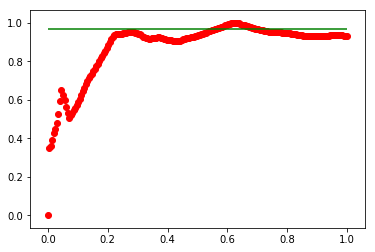

In [61]:
draw_ppl = norm_ppl << train_set
for i in range(1):
    btch = draw_ppl.next_batch(12)
    plt.scatter(btch.time_grid[0], btch.derivative_grid[0], c='r')
    plt.hlines(btch.norm_target[0], 0, 1, colors='g')
    plt.show()

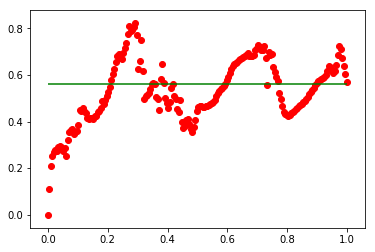

In [62]:
draw_ppl = norm_ppl << test_set
for i in range(1):
    btch = draw_ppl.next_batch(12)
    plt.scatter(btch.time_grid[0], btch.derivative_grid[0], c='r')
    plt.hlines(btch.norm_target[0], 0, 1, colors='g')
    plt.show()

# Обучение модели

In [213]:
import tensorflow as tf

In [230]:
model_config={'inputs': dict(signals={'shape': (GRID_SIZE, 1)},
                             labels={'shape': (1, ), 'name': 'targets'}),
              'body': dict(layout='cnacna', kernel_size=[20, 20, 20], filters=[10, 10, 20]),
              'head': dict(layout='fa', activation=tf.math.softplus, units=1),
              'initial_block/inputs': 'signals',
              'loss': 'mse',
              'optimizer': 'Adam'
#               'optimizer': ('MomentumOptimizer', {'learning_rate': 0.001, 'momentum': 0.5}),
             }

In [234]:
train_ppl = (norm_ppl
              .init_variable('loss', init_on_each_run=list)
              .init_variable('loss_history', init_on_each_run=list)
              .init_model('dynamic', TFModel, 'baseline', config=model_config)
              .train_model('baseline', fetches='loss',
                           feed_dict={'signals': B('derivative_grid'),
                                      'labels': B('norm_target')},
                           save_to=V('loss'), mode='w')
             .update_variable('loss_history', V('loss'), mode='a')
             ) << train_set

test_ppl = (norm_ppl
                  .init_variable('loss', init_on_each_run=0)
                  .init_variable('loss_history', init_on_each_run=list)
                  .import_model('baseline', train_ppl)
                  .predict_model('baseline', fetches=['loss', 'predictions'],
                               feed_dict={'signals': B('derivative_grid'),
                                          'labels': B('norm_target')},
                                        save_to=[V('loss'), B('predictions')], mode='w')
                  .update_variable('loss_history', V('loss'), mode='a')
                  .denormalize(src='predictions', dst='denorm_predictions',
                                         src_range='derivative_range')
                ) << test_set

In [235]:
test_ppl.reset_iter()
train_ppl.reset_iter()

test_loss = []

In [236]:
for i in tqdm(range(1000)):
    btch = train_ppl.next_batch(20, shuffle=True, n_epochs=None, drop_last=True)
    if i % 10 == 0:
        btch2 = test_ppl.next_batch(90, shuffle=True, n_epochs=None, drop_last=True)
        test_loss.append(test_ppl.get_variable('loss'))

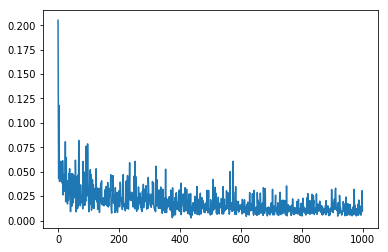

In [220]:
plt.plot(train_ppl.get_variable('loss_history')[:])

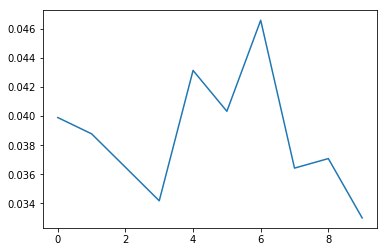

In [238]:
plt.plot(test_loss[-10:])

In [239]:
btch = btch2

In [240]:
btch.target.shape

(90,)

# Анализ результатов

Рассмотрим метрику MAPE

In [241]:
metrics = np.abs(btch.denorm_predictions.reshape(-1) - btch.target.reshape(-1)) / btch.target.reshape(-1)
metrics = metrics.astype(np.float32)

In [242]:
np.mean(metrics)

1.4428217

In [243]:
np.percentile(metrics, q=90)

2.2098491668701192

Посмотрим на гистограмму ошибок без 10 самых плохих предсказаний

(array([28., 26.,  9.,  3.,  4.,  2.,  2.,  1.,  2.,  3.]),
 array([0.00911176, 0.20046725, 0.39182274, 0.58317823, 0.77453372,
        0.96588922, 1.15724471, 1.3486002 , 1.53995569, 1.73131118,
        1.92266667]),
 <a list of 10 Patch objects>)

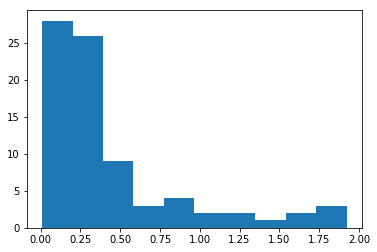

In [244]:
plt.hist(np.sort(metrics)[:-10])

Гистограмма 10 самых плохих предсказаний

(array([7., 1., 1., 0., 0., 0., 0., 0., 0., 1.]),
 array([ 2.18650556,  6.66655495, 11.14660435, 15.62665374, 20.10670314,
        24.58675253, 29.06680193, 33.54685133, 38.02690072, 42.50695012,
        46.98699951]),
 <a list of 10 Patch objects>)

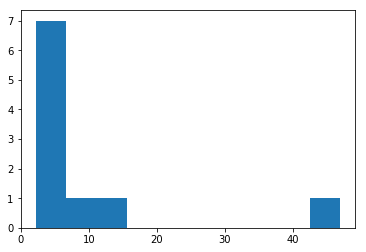

In [246]:
plt.hist(np.sort(metrics)[-10:])

Посмотрим на примеры, на которых мы ошиблись сильнее всего

In [247]:
ix = np.argsort(metrics)

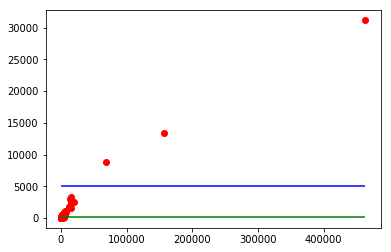

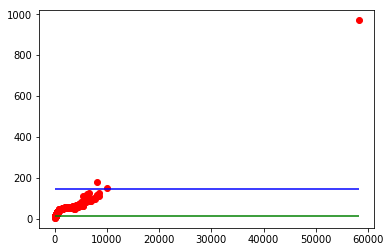

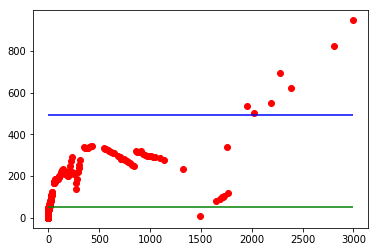

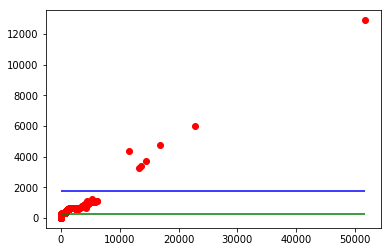

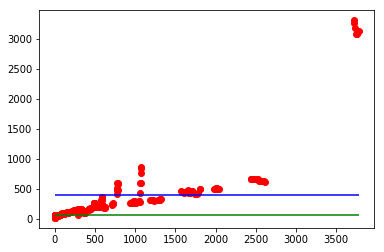

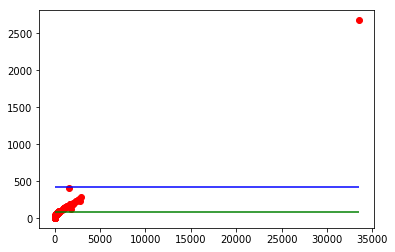

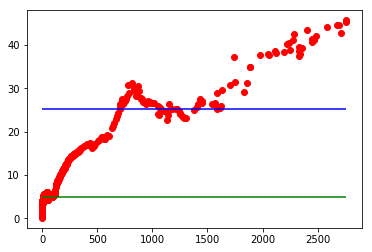

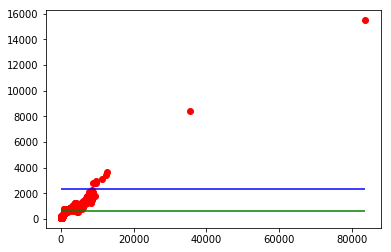

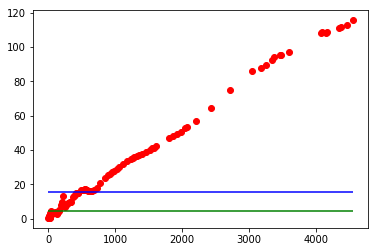

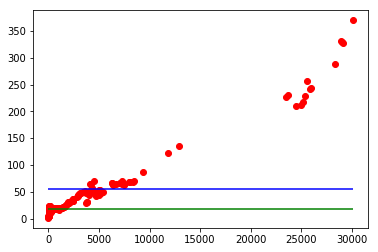

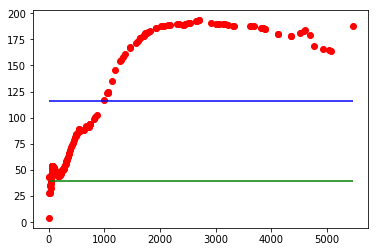

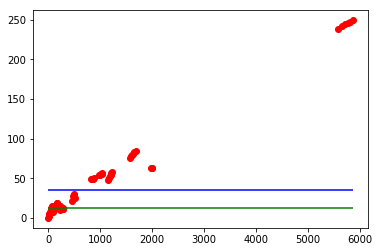

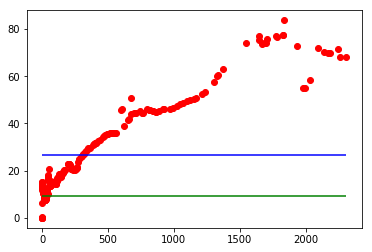

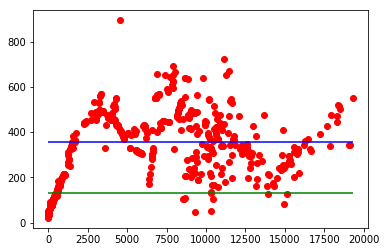

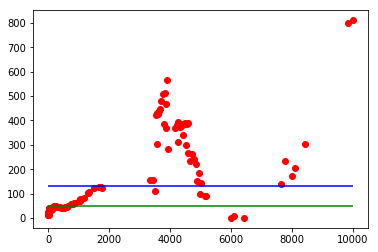

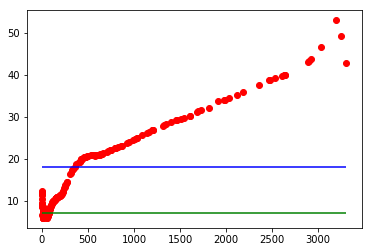

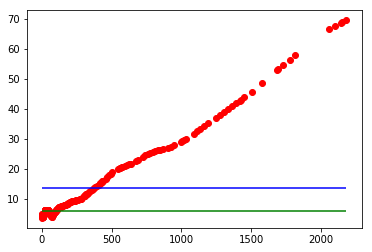

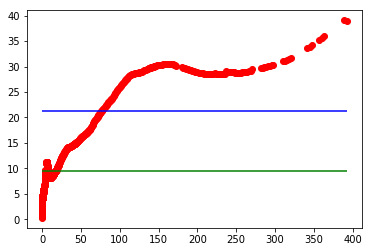

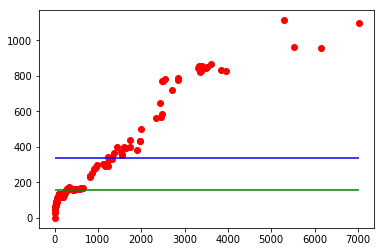

In [249]:
for i in range(1, 20):
    plt.scatter(btch.time[ix][-i], btch.derivative[ix][-i], c='r')
    plt.hlines(btch.target[ix][-i], np.min(btch.time[ix][-i]), np.max(btch.time[ix][-i]), colors='g',
               linestyle='-')
    plt.hlines(btch.denorm_predictions[ix][-i], np.min(btch.time[ix][-i]), 
               np.max(btch.time[ix][-i]), colors='b', linestyle='-')
    plt.show()

Таким образом, мы видим, что рассматриваемый подход очень чувствителен к выбросам и нуждается в переосмыслении.
Или удалении выбросов из данных.